# Initialization
## Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
import os
import sys
import torch
import pickle
from pathlib import Path
cwd = Path().resolve()
twd = os.path.dirname(cwd.__str__())
sys.path.append(twd)

import _pylib.tools as tl
import _pylib.laser as lsr
import _deeplearn.network as dln
import _deeplearn.utility as dlu
import _deeplearn.loss as dll
plt = tl.update_plot_style(plt,'notebook', matplotlib)

# Read epoch info

In [2]:
# Read all epoch files to list
epoch_id = -1
epoch_files = []
for file in os.listdir('.\\'):
    if file.split('.')[-1]=='pth':
        epoch_files.append(file)
        
# Load last epoch state
load_data = torch.load(epoch_files[epoch_id])
history = load_data['history']
print('Loaded epoch %i'%(len(history)))

Loaded epoch 500


# Loss history

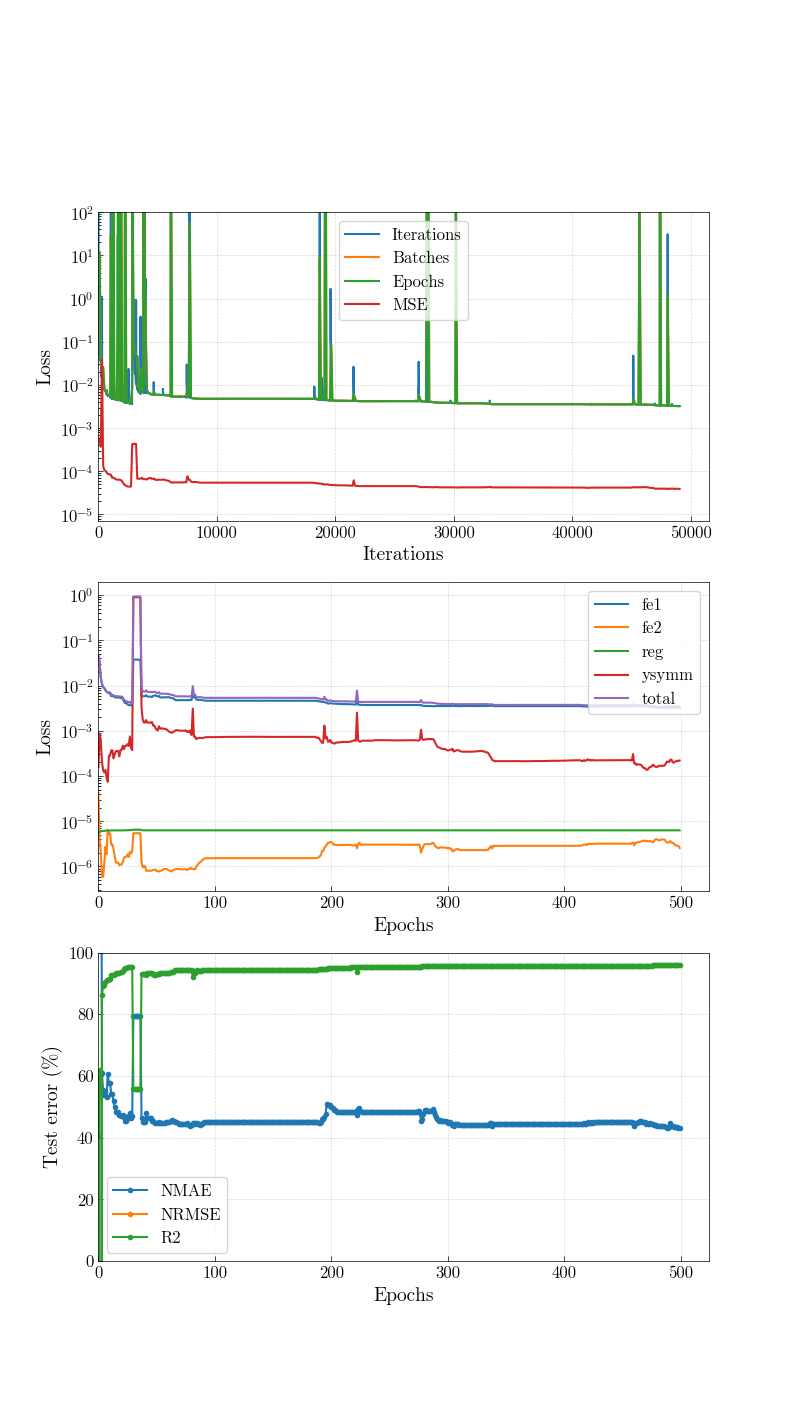

In [3]:
# Extract the data as lists
i_loss = []
b_loss = []
b_iter = []
epoch_dict = {
    'iteration':[],
    'loss':[],
    'MSE':[],
    'NMAE':[],
    'NRMSE':[],
    'R2':[],
}
test_loss_dict = {key:[] for key in history[0]['test']['loss']}
i_counter = 0
for epoch in history:
    for batch in epoch['batches']:
        for iteration in batch['iterations']:
            i_loss.append(iteration['loss'])
            i_counter+=1
        b_loss.append(batch['loss'])
        b_iter.append(i_counter)
    epoch_dict['loss'].append(epoch['loss'])
    epoch_dict['iteration'].append(i_counter)
    epoch_dict['MSE'].append(float(epoch['test']['MSE']))
    epoch_dict['NMAE'].append(float(epoch['test']['NMAE']))
    epoch_dict['NRMSE'].append(float(epoch['test']['NRMSE']))
    epoch_dict['R2'].append(float(epoch['test']['R2']))
    
    for key in epoch['test']['loss']:
        test_loss_dict[key].append(epoch['test']['loss'][key])
epoch_df = pd.DataFrame(epoch_dict)
test_loss_df = pd.DataFrame(test_loss_dict)

%matplotlib widget
mm = (200, 360)  # x value then y value
fig = plt.figure(figsize=(mm[0] / 25.4, mm[1] / 25.4), num=1, clear=True)
gs1 = fig.add_gridspec(ncols=1, nrows=3)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0], sharex=ax2)

ax1.semilogy(i_loss, label='Iterations')
ax1.semilogy(b_iter,b_loss, label='Batches')
ax1.semilogy(epoch_df['iteration'],epoch_df['loss'], label='Epochs')
ax1.semilogy(epoch_df['iteration'],epoch_df['MSE'], label='MSE')
ax1.set_xlim(left=0)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_ylim(top=100)
ax1.legend()

ax2.semilogy(test_loss_df, label=test_loss_df.columns)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend()

ax3.plot(epoch_df.index,epoch_df['NMAE'], label='NMAE', marker='.')
ax3.plot(epoch_df.index,epoch_df['NRMSE'], label='NRMSE', marker='.')
ax3.plot(epoch_df.index,epoch_df['R2'], label='R2', marker='.')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Test error (%)')
ax3.set_xlim(left=0)
ax3.set_ylim(0,100)
ax3.legend()


In [4]:
epoch_df.sort_values(by=['NMAE'])

,iteration,loss,MSE,NMAE,NRMSE,R2
14,1500,3.599992e+11,0.000984,143.476069,842.629205,65.392133
13,1400,7.149303e-03,0.000984,143.476069,842.629205,65.392133
6,700,4.517018e-02,0.001560,154.626458,1060.879220,45.142792
15,1600,6.744631e-03,0.001327,163.431786,978.583954,53.323531
16,1700,6.434619e-03,0.001015,166.589347,855.780158,64.303450
11,1200,1.032283e-02,0.000327,180.620614,485.935226,88.490444
5,600,4.544197e-02,0.001611,195.621689,1078.158164,43.341279
4,500,4.580769e-02,0.001675,225.900725,1099.510117,41.074907
12,1300,7.834691e-03,0.000316,226.493983,477.538416,88.884770
3,400,4.674462e-02,0.001724,282.270377,1115.424815,39.356757


# Load model

In [5]:
STG = { # Settings
    'device_type':'cpu', # cpu|cuda
}

if STG['device_type'] == 'cpu':
    device = 'cpu'
else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
pulse_nfo = torch.load(epoch_files[-1])
pulse_model = dln.NeuralNetPulse(**pulse_nfo['init_pars'])
pulse_model.load_state_dict(pulse_nfo['model_state_dict'])
pulse_model.device = device
pulse_model.to(device)
pulse_model.eval()

events = [{
    'id_L':0,
    'shift_tns':torch.zeros(4),
    'rotate_tns':torch.eye(4).double(),
}]
pulse_model.update_events(events)

# Line plots

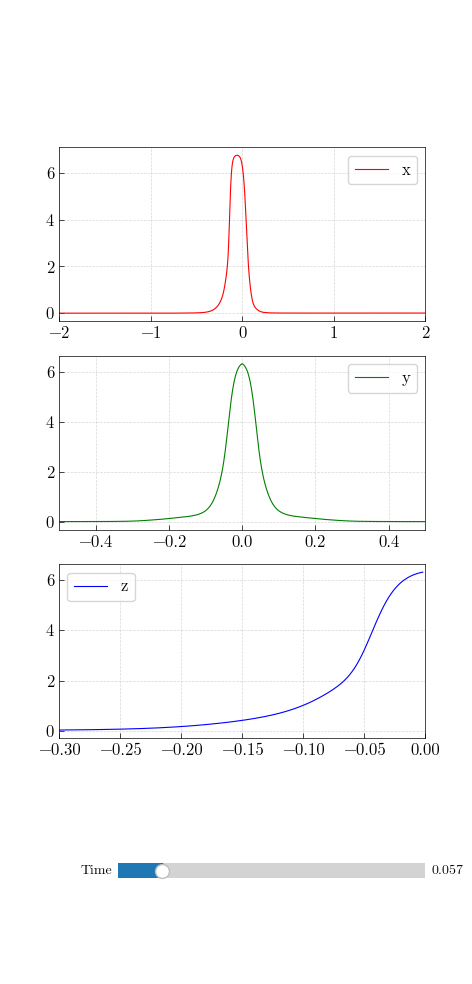

In [6]:
# variables
limits = {
    'x':(-2,2),
    'y':(-0.5,0.5),
    'z':(-0.3,0),
}
anchor = {
    'x':0,
    'y':0,
    'z':0,
}
t_initial = 0.057  # ms
space_step = 0.002
time_step = 1e-5

# Evaluation
inputs = []
for idx, key in enumerate(limits):
    inputs.append(torch.arange(limits[key][0],limits[key][1],space_step).reshape(-1,1))
    inputs[-1] = torch.nn.functional.pad(inputs[-1],(0+idx,3-idx))
    if key == 'x':
        inputs[-1][:,1] = anchor['y']
        inputs[-1][:,2] = anchor['z']
    if key == 'y':
        inputs[-1][:,0] = anchor['x']
        inputs[-1][:,2] = anchor['z']
    if key == 'z':
        inputs[-1][:,0] = anchor['x']
        inputs[-1][:,1] = anchor['y']
    inputs[-1][:,3] = t_initial/1000

responses = []
for in_tns in inputs:
    responses.append(pulse_model.pulsum_memory(in_tns))

%matplotlib widget
mm = (120, 250)  # x value then y value
fig = plt.figure(figsize=(mm[0] / 25.4, mm[1] / 25.4))

plot_settings = {
    'lw':0.8,
}

ax1 = fig.add_subplot(311)
line_x, = ax1.plot(inputs[0][:,0],responses[0], label='x', color='red', **plot_settings)
ax1.set_xlim(limits['x'])

ax2 = fig.add_subplot(312)
line_y, = ax2.plot(inputs[1][:,1],responses[1], label='y', color='green',  **plot_settings)
ax2.set_xlim(limits['y'])

ax3 = fig.add_subplot(313)
line_z, = ax3.plot(inputs[2][:,2],responses[2], label='z', color='blue',  **plot_settings)
ax3.set_xlim(limits['z'])

for ax in [ax1,ax2,ax3]:
    ax.legend()

plt.subplots_adjust(bottom=0.25)

axcolor = 'lightgoldenrodyellow'
axtime = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)

stime = Slider(axtime, 'Time', -0.1, 1, valinit=t_initial, valstep=time_step)

def update(val):
    time = stime.val
    inputs[0][:,3] = time/1000
    inputs[1][:,3] = time/1000
    inputs[2][:,3] = time/1000
    line_x.set_ydata(pulse_model.pulsum_memory(inputs[0]))
    line_y.set_ydata(pulse_model.pulsum_memory(inputs[1]))
    line_z.set_ydata(pulse_model.pulsum_memory(inputs[2]))
    fig.canvas.draw_idle()

stime.on_changed(update)

plt.show()

# Scatter
## Load Data

In [7]:
root = twd
SMP = { # Sampler properties
    'dict_name':'FE Sampler properties',
    'type':'contour',	#simple|ellipse|contour|binned
    'time_subset':[],	# range of times to consider in training, [] for full time
    'test_size':0.2,
    'contour':{
        # 'levels':n|p.arange(1300,0,-100), # list of temperatures
        'levels':[50], # list of temperatures
        'window_ratio':0.6,	# window around each temperature level
        'space_subset':[(-4,-2,-1.5),(4,2,0.00)],
    },
    'binned':{
        'n_bins':20,
        'sample_size':5000,
        'space_subset':[(-4,-2,-1.5),(4,2,0.00)],
    }
}

if os.path.exists(os.path.join(root,'3_sampled_data.pk')):
    data_dict = pickle.load( open( os.path.join(root,'3_sampled_data.pk'), 'rb' ) )
    sample_batch = data_dict['samples']
    label_batch = data_dict['labels']
else:
    model_packs = tl.readModels(
    models_given = [pulse_nfo['fe_model']], 
    root = os.path.join(os.path.dirname(cwd), 'CSV'))
    mref_pack = model_packs.pop(0)
    
    sample_batch, label_batch = dlu.contour_sampler(
        nt_df = mref_pack['nt11'],
        coords_df = mref_pack['coords'],
        time_range = SMP['time_subset'],
        **SMP['contour'])

# Update Events
PRC = {
    'time':8,
    'space':7,
}
laser_tracker = lsr.LaserTracker(os.path.join(root,pulse_nfo['fe_model']['laser']))
pulse_tracker = lsr.PulseTracker(LEO=laser_tracker, pulse_length=pulse_model.init_pars['net_arch']['pulse_length'], rounding_digits=PRC)
pulse_events = pulse_tracker.events
dln.append_transform(pulse_events, device)
pulse_model.update_events(pulse_events)

print('Loaded %s samples and %s labels from FE data.'%(str([s.shape for s in sample_batch]),str([l.shape for l in label_batch])))

Loaded [(17179, 4), (4532735, 4)] samples and [(17179, 1), (4532735, 1)] labels from FE data.


## Plot Scatter

Text(0, 0.5, 'Network Predictions')

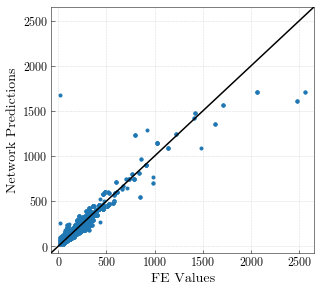

In [11]:
num_per_batch=50e3
sample_chosen = np.array([]).reshape(0,4)
label_chosen = np.array([]).reshape(0,1)
for cur_set in zip(sample_batch, label_batch):
    idx = np.random.randint(len(cur_set[0]), size=int(num_per_batch))
    sample_chosen = np.concatenate((sample_chosen,cur_set[0][idx]),axis=0)
    label_chosen = np.concatenate((label_chosen,cur_set[1][idx]),axis=0)
    
x_ = torch.tensor(sample_chosen, device=pulse_model.device)
u_fe_ = label_chosen

label_transformer = dln.LabelTransform(pulse_model.init_pars['net_arch']['scale_type'])
u_pred_ = label_transformer.u2T(pulse_model.pulsum(x_).cpu().detach().numpy())

u_min = min(min(u_fe_),min(u_pred_))-100
u_max = max(max(u_fe_),max(u_pred_))+100

%matplotlib inline
#%matplotlib widget

# Create figure
mm = (120, 120)  # x value then y value
inches = (mm[0] / 25.4, mm[1] / 25.4)
fig = plt.figure(figsize=inches)
ax1 = fig.add_subplot()
ax1.scatter(u_fe_,u_pred_, marker='.')
ax1.plot([u_min,u_max],[u_min,u_max],color='black')
ax1.set_xlim(u_min,u_max)
ax1.set_ylim(u_min,u_max)
ax1.set_xlabel('FE Values')
ax1.set_ylabel('Network Predictions')

# Grad plot

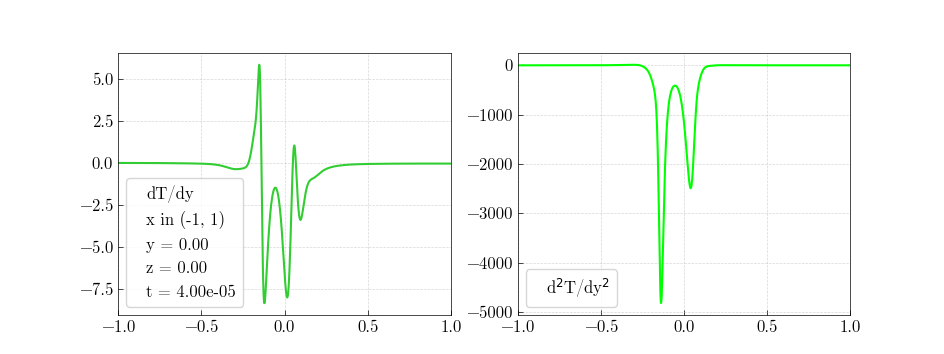

In [10]:
# variables
limits = {'x':(-1,1)}
anchor = {'y':0, 'z':0.0, 't':40e-6} # time in seconds
space_step = 0.002
# Evaluation
input_tns = torch.arange(limits['x'][0],limits['x'][1],space_step).reshape(-1,1)
input_tns = torch.nn.functional.pad(input_tns,(0,3))
input_tns[:,1] = anchor['y']
input_tns[:,2] = anchor['z']
input_tns[:,3] = anchor['t']
du = dll.grad_spacetime(pulse_model, input_tns)

%matplotlib widget
mm = (240, 90);fig = plt.figure(figsize=(mm[0] / 25.4, mm[1] / 25.4))
ax1 = fig.add_subplot(121);ax2 = fig.add_subplot(122);
line_x, = ax1.plot(input_tns[:,0].detach().numpy(),du['y'].detach().numpy(), label='dT/dy', color='limegreen')
line_x, = ax2.plot(input_tns[:,0].detach().numpy(),du['yy'].detach().numpy(), label='d$^2$T/dy$^2$', color='lime')
ax1.plot(0,0,label='x in %s'%(str(limits['x'])));ax1.plot(0,0,label='y = %.2f'%(anchor['y']));ax1.plot(0,0,label='z = %.2f'%(anchor['z']));ax1.plot(0,0,label='t = %.2e'%(anchor['t']))
for ax in [ax1,ax2]:
    ax.set_xlim(limits['x'])
    ax.legend(handlelength=0)